# Predicting turbomachinery failure
## September 2018
### Dr Jose M Albornoz

# Import necessary modules

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import cm
style.use('seaborn-colorblind')
%matplotlib inline

import seaborn as sns

import random
import time
import datetime

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, precision_recall_curve

import os
import pickle

# maximum number of rdataframe ows and columns displayed
pd.set_option('display.max_rows', 50000)
pd.set_option('display.max_columns', 500)

RANDOM_STATE = 801
pd.options.mode.chained_assignment = None

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# 1. - Load failure event data, examine size, field types

In [2]:
df_FE = pd.read_csv('FailureEvents_2015-2017.csv')

In [3]:
df_FE.shape

(4, 3)

In [4]:
df_FE.head()

,Failure,machine stop date,machine restart date
0,1,07/02/2016,23/02/2016
1,2,15/12/2015,17/12/2015
2,3,02/04/2015,14/04/2015
3,4,26/10/2016,27/10/2016


In [5]:
df_FE.dtypes

Failure                  int64
machine stop date       object
machine restart date    object
dtype: object

## 1.1.- Convert date strings to datetime, sort by datetime

In [6]:
df_FE['machine stop date'] = pd.to_datetime(df_FE['machine stop date'], format='%d/%m/%Y')

In [7]:
df_FE['machine restart date'] = pd.to_datetime(df_FE['machine restart date'], format='%d/%m/%Y')

In [8]:
df_FE.sort_values(by='machine stop date', inplace=True)

In [9]:
df_FE

,Failure,machine stop date,machine restart date
2,3,2015-04-02,2015-04-14
1,2,2015-12-15,2015-12-17
0,1,2016-02-07,2016-02-23
3,4,2016-10-26,2016-10-27


# 2. - Load sensor data, examine size, field types

In [10]:
df_SD0 = pd.read_csv('data_2015-2017.csv')

In [11]:
df_SD0.shape

(18216, 33)

In [12]:
df_SD0.head()

,DateTime,sensor 1,sensor 2,sensor 3,sensor 4,sensor 5,sensor 6,sensor 7,sensor 8,sensor 9,sensor 10,sensor 11,sensor 12,sensor 13,sensor 14,sensor 15,sensor 16,sensor 17,sensor 18,sensor 19,sensor 20,sensor 21,sensor 22,sensor 23,sensor 24,sensor 25,sensor 26,sensor 27,sensor 28,sensor 29,sensor 30,sensor 31,sensor 32
0,01/02/2015 00:00,3540.21,3540.21,1835.53,31.45,0.0,0.09,1.81,1.90,13.67,5.77,4.70,23.50,13.56,5340.87,8894.83,94.18,99.12,22.06,21.74,41.07,78.0,79.0,72.0,71.0,75.14,79.0,62.0,63.00,63.0,61.0,82.0,79.16
1,01/02/2015 01:00,3557.45,3557.44,1834.46,31.45,0.0,0.09,1.85,1.83,13.54,5.75,4.72,23.52,13.57,5340.59,8903.39,93.06,99.13,22.42,21.51,41.79,78.0,79.0,72.0,71.0,75.66,79.0,62.0,63.00,63.0,61.0,82.0,79.16
2,01/02/2015 02:00,3570.47,3570.47,1836.77,31.45,0.0,0.10,1.84,1.77,13.69,5.76,4.77,23.51,13.53,5340.32,8906.25,91.61,98.99,22.00,21.21,41.20,78.0,79.0,72.0,71.0,75.48,79.0,62.0,62.98,63.0,61.0,82.0,79.00
3,01/02/2015 03:00,3576.26,3576.26,1839.96,31.45,0.0,0.10,1.85,1.83,13.67,5.80,4.77,23.49,13.61,5341.18,8897.71,90.80,99.03,21.09,20.80,40.36,78.0,79.0,72.0,71.0,75.37,79.0,62.0,62.68,63.0,61.0,82.0,79.00
4,01/02/2015 04:00,3585.47,3585.49,1838.84,31.45,0.0,0.10,1.83,1.87,13.68,5.84,4.76,23.55,13.55,5340.58,8905.01,89.50,98.61,20.31,20.33,40.39,78.0,79.0,72.0,71.0,75.97,79.0,62.0,62.98,63.0,61.0,82.0,79.16


In [13]:
df_SD0.tail()

,DateTime,sensor 1,sensor 2,sensor 3,sensor 4,sensor 5,sensor 6,sensor 7,sensor 8,sensor 9,sensor 10,sensor 11,sensor 12,sensor 13,sensor 14,sensor 15,sensor 16,sensor 17,sensor 18,sensor 19,sensor 20,sensor 21,sensor 22,sensor 23,sensor 24,sensor 25,sensor 26,sensor 27,sensor 28,sensor 29,sensor 30,sensor 31,sensor 32
18211,28/02/2017 19:00,3825.07,3825.07,1851.29,0.05,0.04,0.10,1.58,1.56,13.81,5.69,4.39,23.59,13.67,5605.96,9625.47,100.60,89.73,16.83,21.63,35.41,72.0,68.60,73.65,72.00,77.00,81.50,60.0,63.0,62.56,65.0,82.0,81.92
18212,28/02/2017 20:00,3824.17,3824.17,1854.29,0.05,0.04,0.10,1.53,1.55,13.79,5.62,4.43,23.62,13.67,5604.11,9606.02,100.18,88.89,16.44,20.64,36.94,72.0,68.07,73.98,72.00,77.00,81.81,60.0,63.0,62.00,65.0,82.0,81.57
18213,28/02/2017 21:00,3873.64,3873.64,1853.19,0.05,0.04,0.11,1.58,1.56,13.89,5.76,4.59,23.53,13.69,5608.37,9689.81,99.09,88.86,16.22,19.71,36.77,72.0,68.59,74.00,72.00,77.66,82.00,60.0,63.0,62.78,65.0,82.0,81.42
18214,28/02/2017 22:00,3834.29,3834.29,1854.44,0.05,0.04,0.11,1.65,1.61,13.93,5.71,4.55,23.61,13.68,5608.35,9671.74,97.90,100.48,15.75,19.05,43.13,72.0,68.90,73.28,72.00,77.00,81.03,60.0,63.0,62.77,65.0,82.0,81.57
18215,28/02/2017 23:00,3753.84,3753.83,1858.60,0.05,0.04,0.10,1.65,1.60,13.89,5.65,4.53,23.61,13.71,5606.48,9578.85,98.63,103.94,15.37,18.54,47.54,72.0,68.09,73.19,71.65,77.00,80.18,60.0,63.0,62.04,65.0,82.0,81.25


In [14]:
df_SD0.dtypes

DateTime      object
sensor 1     float64
sensor 2     float64
sensor 3     float64
sensor 4     float64
sensor 5     float64
sensor 6     float64
sensor 7     float64
sensor 8     float64
sensor 9     float64
sensor 10    float64
sensor 11    float64
sensor 12    float64
sensor 13    float64
sensor 14    float64
sensor 15    float64
sensor 16    float64
sensor 17    float64
sensor 18    float64
sensor 19    float64
sensor 20    float64
sensor 21    float64
sensor 22    float64
sensor 23    float64
sensor 24    float64
sensor 25    float64
sensor 26    float64
sensor 27    float64
sensor 28    float64
sensor 29    float64
sensor 30    float64
sensor 31    float64
sensor 32    float64
dtype: object

## 2.1.- Convert timestamp strings to datetime, sort by timestamp

In [15]:
df_SD0['DateTime'] = pd.to_datetime(df_SD0['DateTime'], format = "%d/%m/%Y %H:%M")

In [16]:
df_SD0['DateTime'].min()

Timestamp('2015-02-01 00:00:00')

In [17]:
df_SD0['DateTime'].max()

Timestamp('2017-02-28 23:00:00')

In [18]:
df_SD0.sort_values(by='DateTime', inplace=True)

In [19]:
df_SD0.head()

,DateTime,sensor 1,sensor 2,sensor 3,sensor 4,sensor 5,sensor 6,sensor 7,sensor 8,sensor 9,sensor 10,sensor 11,sensor 12,sensor 13,sensor 14,sensor 15,sensor 16,sensor 17,sensor 18,sensor 19,sensor 20,sensor 21,sensor 22,sensor 23,sensor 24,sensor 25,sensor 26,sensor 27,sensor 28,sensor 29,sensor 30,sensor 31,sensor 32
0,2015-02-01 00:00:00,3540.21,3540.21,1835.53,31.45,0.0,0.09,1.81,1.90,13.67,5.77,4.70,23.50,13.56,5340.87,8894.83,94.18,99.12,22.06,21.74,41.07,78.0,79.0,72.0,71.0,75.14,79.0,62.0,63.00,63.0,61.0,82.0,79.16
1,2015-02-01 01:00:00,3557.45,3557.44,1834.46,31.45,0.0,0.09,1.85,1.83,13.54,5.75,4.72,23.52,13.57,5340.59,8903.39,93.06,99.13,22.42,21.51,41.79,78.0,79.0,72.0,71.0,75.66,79.0,62.0,63.00,63.0,61.0,82.0,79.16
2,2015-02-01 02:00:00,3570.47,3570.47,1836.77,31.45,0.0,0.10,1.84,1.77,13.69,5.76,4.77,23.51,13.53,5340.32,8906.25,91.61,98.99,22.00,21.21,41.20,78.0,79.0,72.0,71.0,75.48,79.0,62.0,62.98,63.0,61.0,82.0,79.00
3,2015-02-01 03:00:00,3576.26,3576.26,1839.96,31.45,0.0,0.10,1.85,1.83,13.67,5.80,4.77,23.49,13.61,5341.18,8897.71,90.80,99.03,21.09,20.80,40.36,78.0,79.0,72.0,71.0,75.37,79.0,62.0,62.68,63.0,61.0,82.0,79.00
4,2015-02-01 04:00:00,3585.47,3585.49,1838.84,31.45,0.0,0.10,1.83,1.87,13.68,5.84,4.76,23.55,13.55,5340.58,8905.01,89.50,98.61,20.31,20.33,40.39,78.0,79.0,72.0,71.0,75.97,79.0,62.0,62.98,63.0,61.0,82.0,79.16


# 2. - Exploratory Data Analysis

## 2.1.- Missing values in sensor data?

In [20]:
df_SD0.isnull().sum()

DateTime     0
sensor 1     0
sensor 2     0
sensor 3     0
sensor 4     0
sensor 5     0
sensor 6     0
sensor 7     0
sensor 8     0
sensor 9     0
sensor 10    0
sensor 11    0
sensor 12    0
sensor 13    0
sensor 14    0
sensor 15    0
sensor 16    0
sensor 17    0
sensor 18    0
sensor 19    0
sensor 20    0
sensor 21    0
sensor 22    0
sensor 23    0
sensor 24    0
sensor 25    0
sensor 26    0
sensor 27    0
sensor 28    0
sensor 29    0
sensor 30    0
sensor 31    0
sensor 32    0
dtype: int64

There are no missing values in the raw sensor data

## 2.2.- Missing timestamps in sensor data?

In [21]:
df_SD1 = df_SD0.resample('1H', on='DateTime').mean()

In [22]:
df_SD1.shape

(18216, 32)

In [23]:
df_SD1.isnull().sum()

sensor 1     0
sensor 2     0
sensor 3     0
sensor 4     0
sensor 5     0
sensor 6     0
sensor 7     0
sensor 8     0
sensor 9     0
sensor 10    0
sensor 11    0
sensor 12    0
sensor 13    0
sensor 14    0
sensor 15    0
sensor 16    0
sensor 17    0
sensor 18    0
sensor 19    0
sensor 20    0
sensor 21    0
sensor 22    0
sensor 23    0
sensor 24    0
sensor 25    0
sensor 26    0
sensor 27    0
sensor 28    0
sensor 29    0
sensor 30    0
sensor 31    0
sensor 32    0
dtype: int64

In [24]:
df_SD1.reset_index(inplace=True)

There are no missing timestamps in the sensor data.

## 2.3.- Generate target variable to signal machinery is stopped

We will introduce a target variable to signal when the machinery has failed (1) or operating normally (0)

In [25]:
df_SD1['stopped'] = 0

In [26]:
df_SD1.loc[(df_SD1['DateTime'] >= df_FE.iloc[0,1]) & (df_SD1['DateTime'] < df_FE.iloc[0,2]),'stopped'] = 1
df_SD1.loc[(df_SD1['DateTime'] >= df_FE.iloc[1,1]) & (df_SD1['DateTime'] < df_FE.iloc[1,2]),'stopped'] = 1
df_SD1.loc[(df_SD1['DateTime'] >= df_FE.iloc[2,1]) & (df_SD1['DateTime'] < df_FE.iloc[2,2]),'stopped'] = 1
df_SD1.loc[(df_SD1['DateTime'] >= df_FE.iloc[3,1]) & (df_SD1['DateTime'] < df_FE.iloc[3,2]),'stopped'] = 1

## 2.4.- Exploratory plots

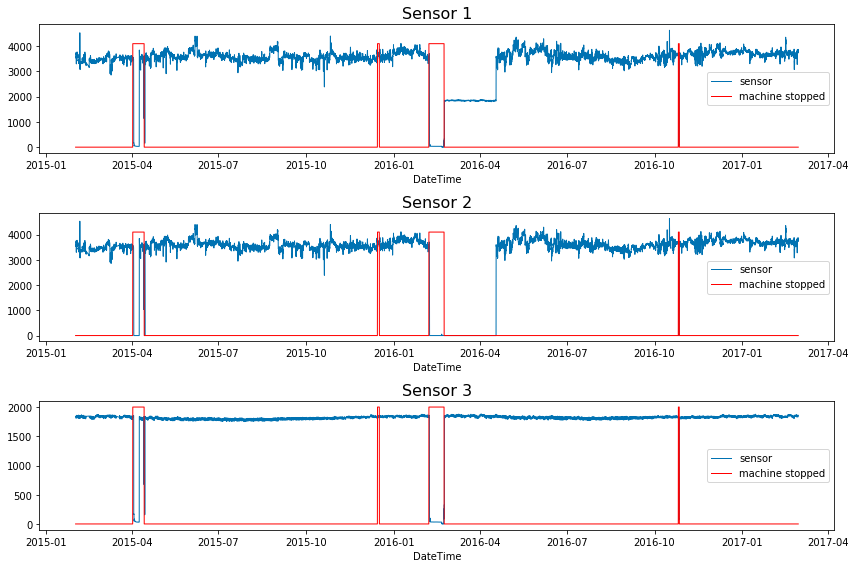

In [28]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,8))
ax1.plot(df_SD1['DateTime'], df_SD1['sensor 1'], linewidth=1, label='sensor')
ax1.plot(df_SD1['DateTime'], df_SD1['stopped']*4100, color = 'r', linewidth=1, label='machine stopped')

ax2.plot(df_SD1['DateTime'], df_SD1['sensor 2'], linewidth=1, label='sensor')
ax2.plot(df_SD1['DateTime'], df_SD1['stopped']*4100, color = 'r', linewidth=1, label='machine stopped')

ax3.plot(df_SD1['DateTime'], df_SD1['sensor 3'], linewidth=1, label='sensor')
ax3.plot(df_SD1['DateTime'], df_SD1['stopped']*2000, color = 'r', linewidth=1, label='machine stopped')

ax1.set_title('Sensor 1', fontsize=16)
ax2.set_title('Sensor 2', fontsize=16)
ax3.set_title('Sensor 3', fontsize=16)

ax1.set_xlabel('DateTime')
ax2.set_xlabel('DateTime')
ax3.set_xlabel('DateTime')

ax1.legend(loc='best')
ax2.legend(loc='best')
ax3.legend(loc='best')

plt.tight_layout()

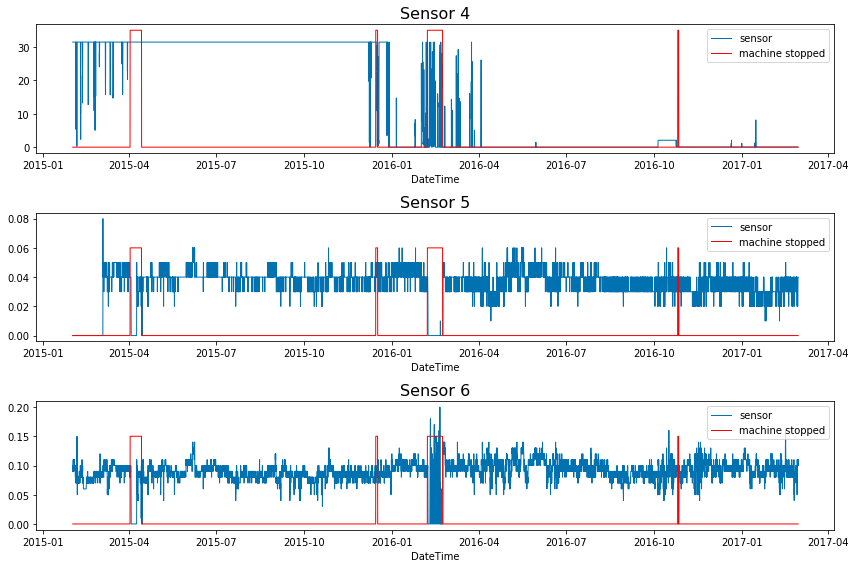

In [29]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,8))
ax1.plot(df_SD1['DateTime'], df_SD1['sensor 4'], linewidth=1, label='sensor')
ax1.plot(df_SD1['DateTime'], df_SD1['stopped']*35, color = 'r', linewidth=1, label='machine stopped')

ax2.plot(df_SD1['DateTime'], df_SD1['sensor 5'], linewidth=1, label='sensor')
ax2.plot(df_SD1['DateTime'], df_SD1['stopped']*0.06, color = 'r', linewidth=1, label='machine stopped')

ax3.plot(df_SD1['DateTime'], df_SD1['sensor 6'], linewidth=1, label='sensor')
ax3.plot(df_SD1['DateTime'], df_SD1['stopped']*0.15, color = 'r', linewidth=1, label='machine stopped')

ax1.set_title('Sensor 4', fontsize=16)
ax2.set_title('Sensor 5', fontsize=16)
ax3.set_title('Sensor 6', fontsize=16)

ax1.set_xlabel('DateTime')
ax2.set_xlabel('DateTime')
ax3.set_xlabel('DateTime')

ax1.legend(loc='best')
ax2.legend(loc='best')
ax3.legend(loc='best')

plt.tight_layout()

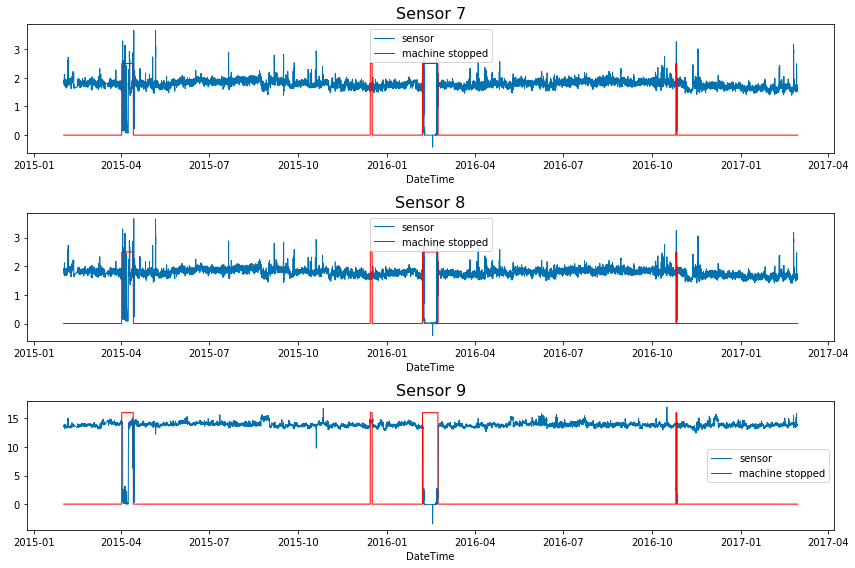

In [30]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,8))
ax1.plot(df_SD1['DateTime'], df_SD1['sensor 7'], linewidth=1, label='sensor')
ax1.plot(df_SD1['DateTime'], df_SD1['stopped']*2.5, color = 'r', linewidth=1, label='machine stopped')

ax2.plot(df_SD1['DateTime'], df_SD1['sensor 8'], linewidth=1, label='sensor')
ax2.plot(df_SD1['DateTime'], df_SD1['stopped']*2.5, color = 'r', linewidth=1, label='machine stopped')

ax3.plot(df_SD1['DateTime'], df_SD1['sensor 9'], linewidth=1, label='sensor')
ax3.plot(df_SD1['DateTime'], df_SD1['stopped']*16, color = 'r', linewidth=1, label='machine stopped')

ax1.set_title('Sensor 7', fontsize=16)
ax2.set_title('Sensor 8', fontsize=16)
ax3.set_title('Sensor 9', fontsize=16)

ax1.set_xlabel('DateTime')
ax2.set_xlabel('DateTime')
ax3.set_xlabel('DateTime')

ax1.legend(loc='best')
ax2.legend(loc='best')
ax3.legend(loc='best')

plt.savefig('correlation.png')

plt.tight_layout()

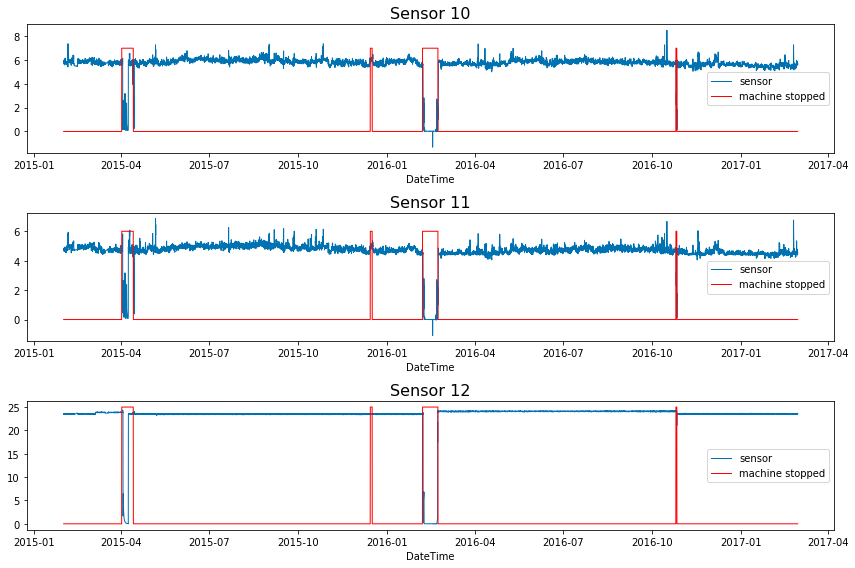

In [31]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,8))
ax1.plot(df_SD1['DateTime'], df_SD1['sensor 10'], linewidth=1, label='sensor')
ax1.plot(df_SD1['DateTime'], df_SD1['stopped']*7, color = 'r', linewidth=1, label='machine stopped')

ax2.plot(df_SD1['DateTime'], df_SD1['sensor 11'], linewidth=1, label='sensor')
ax2.plot(df_SD1['DateTime'], df_SD1['stopped']*6, color = 'r', linewidth=1, label='machine stopped')

ax3.plot(df_SD1['DateTime'], df_SD1['sensor 12'], linewidth=1, label='sensor')
ax3.plot(df_SD1['DateTime'], df_SD1['stopped']*25, color = 'r', linewidth=1, label='machine stopped')

ax1.set_title('Sensor 10', fontsize=16)
ax2.set_title('Sensor 11', fontsize=16)
ax3.set_title('Sensor 12', fontsize=16)

ax1.set_xlabel('DateTime')
ax2.set_xlabel('DateTime')
ax3.set_xlabel('DateTime')

ax1.legend(loc='best')
ax2.legend(loc='best')
ax3.legend(loc='best')

plt.tight_layout()

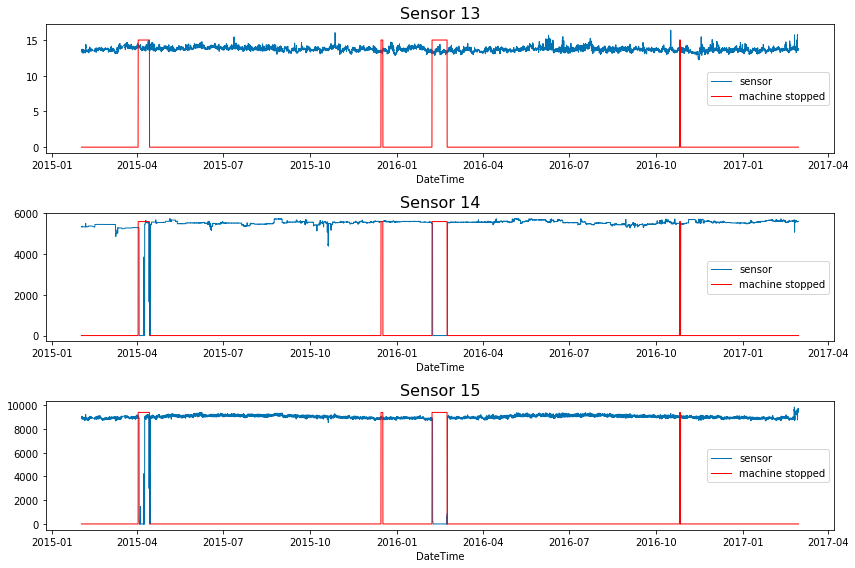

In [32]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,8))
ax1.plot(df_SD1['DateTime'], df_SD1['sensor 13'], linewidth=1, label='sensor')
ax1.plot(df_SD1['DateTime'], df_SD1['stopped']*15, color = 'r', linewidth=1, label='machine stopped')

ax2.plot(df_SD1['DateTime'], df_SD1['sensor 14'], linewidth=1, label='sensor')
ax2.plot(df_SD1['DateTime'], df_SD1['stopped']*5600, color = 'r', linewidth=1, label='machine stopped')

ax3.plot(df_SD1['DateTime'], df_SD1['sensor 15'], linewidth=1, label='sensor')
ax3.plot(df_SD1['DateTime'], df_SD1['stopped']*9400, color = 'r', linewidth=1, label='machine stopped')

ax1.set_title('Sensor 13', fontsize=16)
ax2.set_title('Sensor 14', fontsize=16)
ax3.set_title('Sensor 15', fontsize=16)

ax1.set_xlabel('DateTime')
ax2.set_xlabel('DateTime')
ax3.set_xlabel('DateTime')

ax1.legend(loc='best')
ax2.legend(loc='best')
ax3.legend(loc='best')

plt.tight_layout()

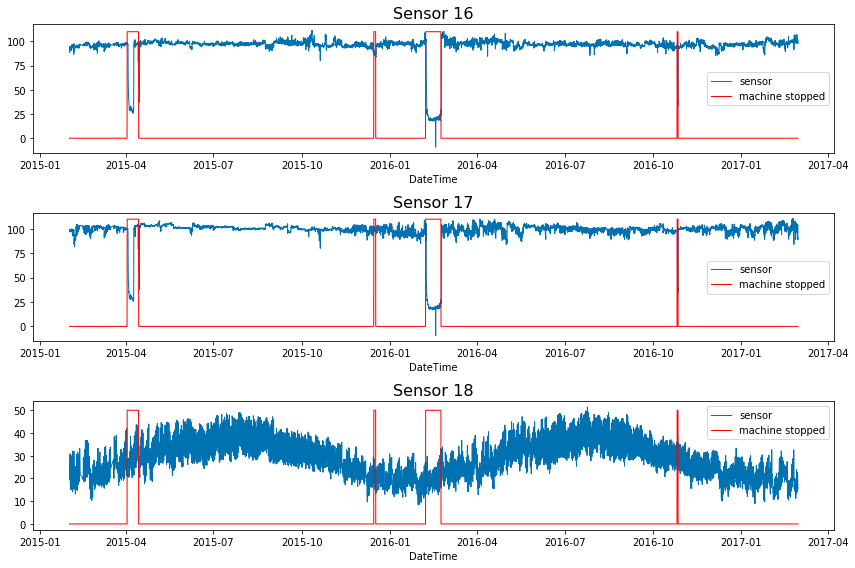

In [33]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,8))
ax1.plot(df_SD1['DateTime'], df_SD1['sensor 16'], linewidth=1, label='sensor')
ax1.plot(df_SD1['DateTime'], df_SD1['stopped']*110, color = 'r', linewidth=1, label='machine stopped')

ax2.plot(df_SD1['DateTime'], df_SD1['sensor 17'], linewidth=1, label='sensor')
ax2.plot(df_SD1['DateTime'], df_SD1['stopped']*110, color = 'r', linewidth=1, label='machine stopped')

ax3.plot(df_SD1['DateTime'], df_SD1['sensor 18'], linewidth=1, label='sensor')
ax3.plot(df_SD1['DateTime'], df_SD1['stopped']*50, color = 'r', linewidth=1, label='machine stopped')

ax1.set_title('Sensor 16', fontsize=16)
ax2.set_title('Sensor 17', fontsize=16)
ax3.set_title('Sensor 18', fontsize=16)

ax1.set_xlabel('DateTime')
ax2.set_xlabel('DateTime')
ax3.set_xlabel('DateTime')

ax1.legend(loc='best')
ax2.legend(loc='best')
ax3.legend(loc='best')

plt.tight_layout()

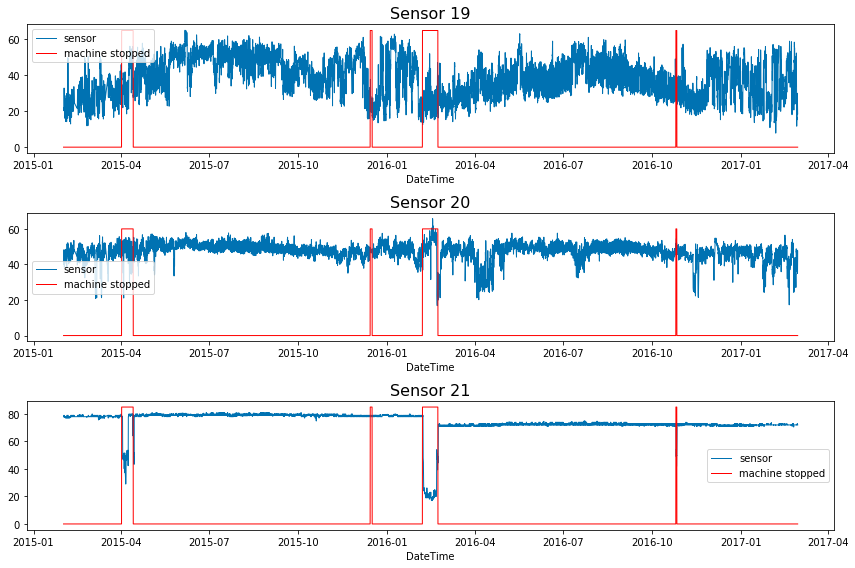

In [34]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,8))
ax1.plot(df_SD1['DateTime'], df_SD1['sensor 19'], linewidth=1, label='sensor')
ax1.plot(df_SD1['DateTime'], df_SD1['stopped']*65, color = 'r', linewidth=1, label='machine stopped')

ax2.plot(df_SD1['DateTime'], df_SD1['sensor 20'], linewidth=1, label='sensor')
ax2.plot(df_SD1['DateTime'], df_SD1['stopped']*60, color = 'r', linewidth=1, label='machine stopped')

ax3.plot(df_SD1['DateTime'], df_SD1['sensor 21'], linewidth=1, label='sensor')
ax3.plot(df_SD1['DateTime'], df_SD1['stopped']*85, color = 'r', linewidth=1, label='machine stopped')

ax1.set_title('Sensor 19', fontsize=16)
ax2.set_title('Sensor 20', fontsize=16)
ax3.set_title('Sensor 21', fontsize=16)

ax1.set_xlabel('DateTime')
ax2.set_xlabel('DateTime')
ax3.set_xlabel('DateTime')

ax1.legend(loc='best')
ax2.legend(loc='best')
ax3.legend(loc='best')

plt.tight_layout()

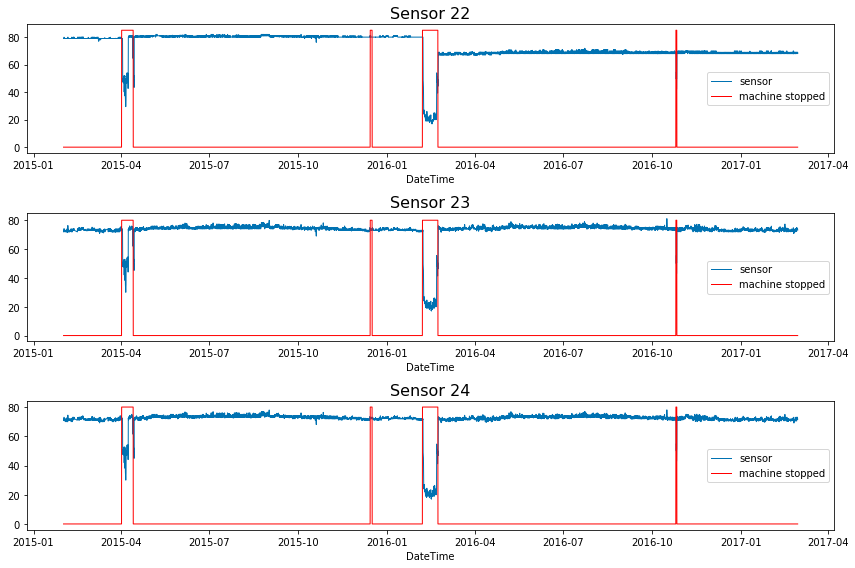

In [35]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,8))
ax1.plot(df_SD1['DateTime'], df_SD1['sensor 22'], linewidth=1, label='sensor')
ax1.plot(df_SD1['DateTime'], df_SD1['stopped']*85, color = 'r', linewidth=1, label='machine stopped')

ax2.plot(df_SD1['DateTime'], df_SD1['sensor 23'], linewidth=1, label='sensor')
ax2.plot(df_SD1['DateTime'], df_SD1['stopped']*80, color = 'r', linewidth=1, label='machine stopped')

ax3.plot(df_SD1['DateTime'], df_SD1['sensor 24'], linewidth=1, label='sensor')
ax3.plot(df_SD1['DateTime'], df_SD1['stopped']*80, color = 'r', linewidth=1, label='machine stopped')

ax1.set_title('Sensor 22', fontsize=16)
ax2.set_title('Sensor 23', fontsize=16)
ax3.set_title('Sensor 24', fontsize=16)

ax1.set_xlabel('DateTime')
ax2.set_xlabel('DateTime')
ax3.set_xlabel('DateTime')

ax1.legend(loc='best')
ax2.legend(loc='best')
ax3.legend(loc='best')

plt.tight_layout()

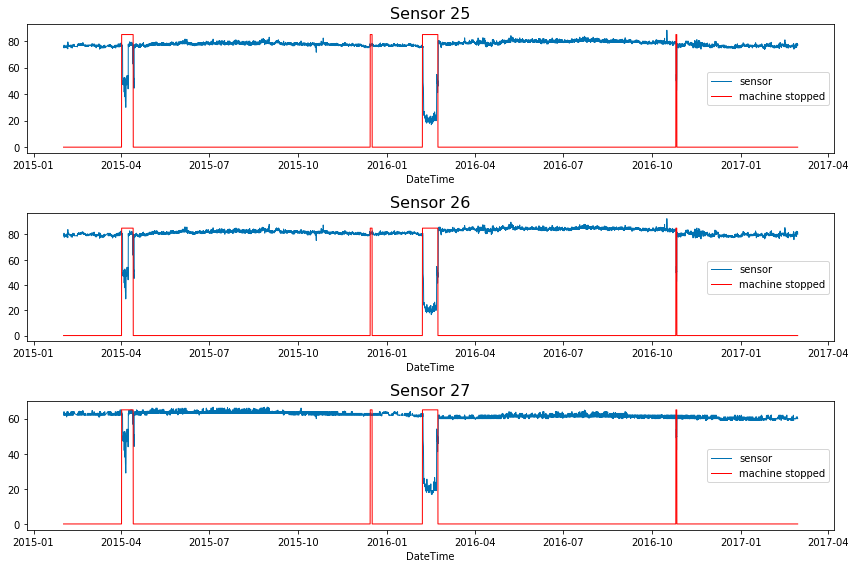

In [36]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,8))
ax1.plot(df_SD1['DateTime'], df_SD1['sensor 25'], linewidth=1, label='sensor')
ax1.plot(df_SD1['DateTime'], df_SD1['stopped']*85, color = 'r', linewidth=1, label='machine stopped')

ax2.plot(df_SD1['DateTime'], df_SD1['sensor 26'], linewidth=1, label='sensor')
ax2.plot(df_SD1['DateTime'], df_SD1['stopped']*85, color = 'r', linewidth=1, label='machine stopped')

ax3.plot(df_SD1['DateTime'], df_SD1['sensor 27'], linewidth=1, label='sensor')
ax3.plot(df_SD1['DateTime'], df_SD1['stopped']*65, color = 'r', linewidth=1, label='machine stopped')

ax1.set_title('Sensor 25', fontsize=16)
ax2.set_title('Sensor 26', fontsize=16)
ax3.set_title('Sensor 27', fontsize=16)

ax1.set_xlabel('DateTime')
ax2.set_xlabel('DateTime')
ax3.set_xlabel('DateTime')

ax1.legend(loc='best')
ax2.legend(loc='best')
ax3.legend(loc='best')

plt.tight_layout()

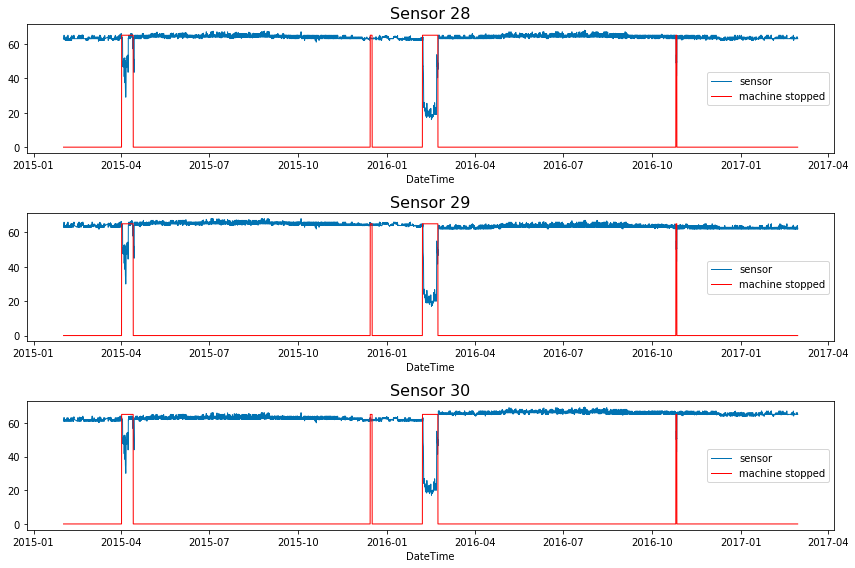

In [37]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,8))
ax1.plot(df_SD1['DateTime'], df_SD1['sensor 28'], linewidth=1, label='sensor')
ax1.plot(df_SD1['DateTime'], df_SD1['stopped']*65, color = 'r', linewidth=1, label='machine stopped')

ax2.plot(df_SD1['DateTime'], df_SD1['sensor 29'], linewidth=1, label='sensor')
ax2.plot(df_SD1['DateTime'], df_SD1['stopped']*65, color = 'r', linewidth=1, label='machine stopped')

ax3.plot(df_SD1['DateTime'], df_SD1['sensor 30'], linewidth=1, label='sensor')
ax3.plot(df_SD1['DateTime'], df_SD1['stopped']*65, color = 'r', linewidth=1, label='machine stopped')

ax1.set_title('Sensor 28', fontsize=16)
ax2.set_title('Sensor 29', fontsize=16)
ax3.set_title('Sensor 30', fontsize=16)

ax1.set_xlabel('DateTime')
ax2.set_xlabel('DateTime')
ax3.set_xlabel('DateTime')

ax1.legend(loc='best')
ax2.legend(loc='best')
ax3.legend(loc='best')

plt.tight_layout()

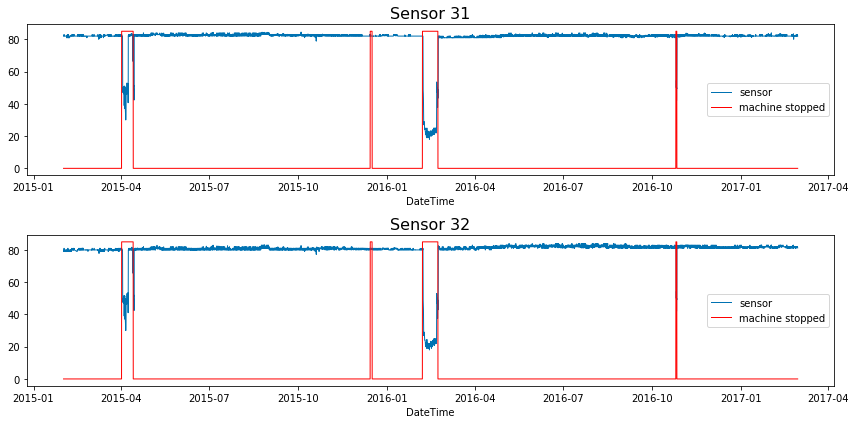

In [38]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,6))
ax1.plot(df_SD1['DateTime'], df_SD1['sensor 31'], linewidth=1, label='sensor')
ax1.plot(df_SD1['DateTime'], df_SD1['stopped']*85, color = 'r', linewidth=1, label='machine stopped')

ax2.plot(df_SD1['DateTime'], df_SD1['sensor 32'], linewidth=1, label='sensor')
ax2.plot(df_SD1['DateTime'], df_SD1['stopped']*85, color = 'r', linewidth=1, label='machine stopped')

ax1.set_title('Sensor 31', fontsize=16)
ax2.set_title('Sensor 32', fontsize=16)

ax1.set_xlabel('DateTime')
ax2.set_xlabel('DateTime')

ax1.legend(loc='best')
ax2.legend(loc='best')

plt.tight_layout()

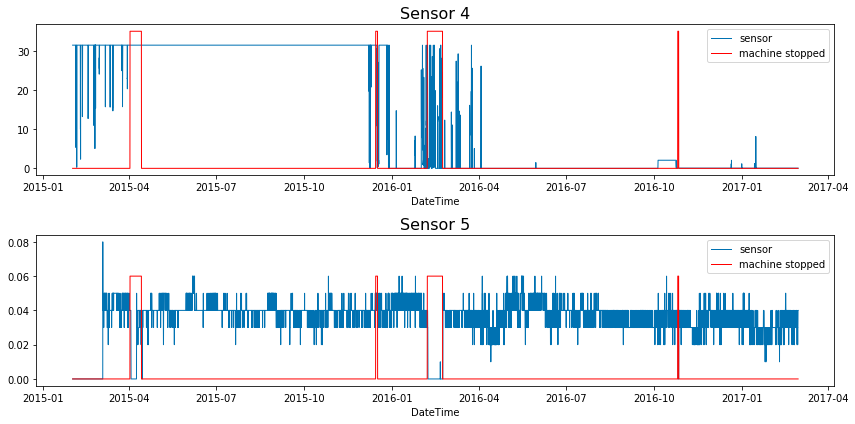

In [39]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,6))
ax1.plot(df_SD1['DateTime'], df_SD1['sensor 4'], linewidth=1, label='sensor')
ax1.plot(df_SD1['DateTime'], df_SD1['stopped']*35, color = 'r', linewidth=1, label='machine stopped')

ax2.plot(df_SD1['DateTime'], df_SD1['sensor 5'], linewidth=1, label='sensor')
ax2.plot(df_SD1['DateTime'], df_SD1['stopped']*0.06, color = 'r', linewidth=1, label='machine stopped')

ax1.set_title('Sensor 4', fontsize=16)
ax2.set_title('Sensor 5', fontsize=16)

ax1.set_xlabel('DateTime')
ax2.set_xlabel('DateTime')

ax1.legend(loc='best')
ax2.legend(loc='best')

plt.tight_layout()

From the above exploratory plots we see that:
1. There is a strong correlation between data from several sensors (e.g. sensors 29, 30, 31, and 32)
2. Data from some sensors do not exhibit this correlation and therefore will not be useful for the model (e.g. sensor 13)
3. There is a clear correlation between machine failure and most of the sensor data. This is very encouraging since there will be a good class separation in feature space, which is especially important given that we are dealing with a strongly imbalance dataset.
4. Data from sensors 5 and 4 looks pretty much like noise


## 2.4. - Class balance

We now consider that each point in time is labeled by column **stopped**; we now want to determine the proportion between the classes represented by the states *stopped* (1) and *operating normally* (0):

In [40]:
df_SD2 = df_SD1.dropna()

In [41]:
np.bincount(df_SD2['stopped'])

array([17472,   744])

In [42]:
np.bincount(df_SD2['stopped'])*100/len(df_SD2)

array([95.91567852,  4.08432148])

There is a strong class imbalance in the target variable **stopped**. It must be stressed that the success of our model will depend on how how well separated are the classes in feature space.

## 2.5. Box plots for sensor data

We now generate box plots for the sensor data, the idea being: 
1. Verify that there are features that are good discriminators between classes 
2. Inform possible feature engineering.

[Text(0, 0, 'stopped = 0'), Text(0, 0, 'stopped = 1')]

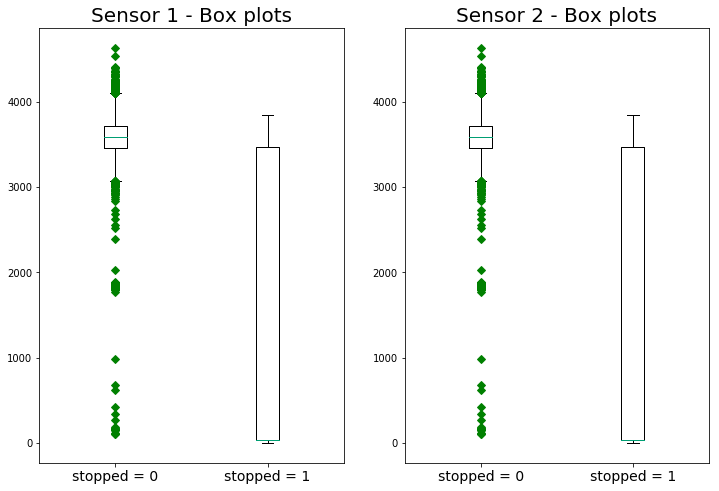

In [43]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))
ax1.boxplot([df_SD2[df_SD2['stopped'] == 0]['sensor 1'], df_SD2[df_SD2['stopped'] == 1]['sensor 1']], 0, 'gD')
ax2.boxplot([df_SD2[df_SD2['stopped'] == 0]['sensor 1'], df_SD2[df_SD2['stopped'] == 1]['sensor 1']], 0, 'gD')

ax1.set_title('Sensor 1 - Box plots', fontsize=20)
ax2.set_title('Sensor 2 - Box plots', fontsize=20)

labels = ['stopped = 0', 'stopped = 1']
ax1.set_xticklabels(labels, fontsize=14)
ax2.set_xticklabels(labels, fontsize=14)

[Text(0, 0, 'stopped = 0'), Text(0, 0, 'stopped = 1')]

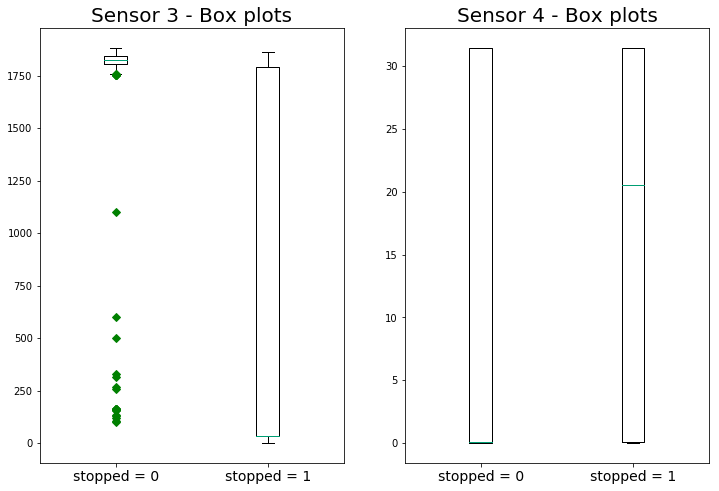

In [44]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))
ax1.boxplot([df_SD2[df_SD2['stopped'] == 0]['sensor 3'], df_SD2[df_SD2['stopped'] == 1]['sensor 3']], 0, 'gD')
ax2.boxplot([df_SD2[df_SD2['stopped'] == 0]['sensor 4'], df_SD2[df_SD2['stopped'] == 1]['sensor 4']], 0, 'gD')

ax1.set_title('Sensor 3 - Box plots', fontsize=20)
ax2.set_title('Sensor 4 - Box plots', fontsize=20)

labels = ['stopped = 0', 'stopped = 1']
ax1.set_xticklabels(labels, fontsize=14)
ax2.set_xticklabels(labels, fontsize=14)

[Text(0, 0, 'stopped = 0'), Text(0, 0, 'stopped = 1')]

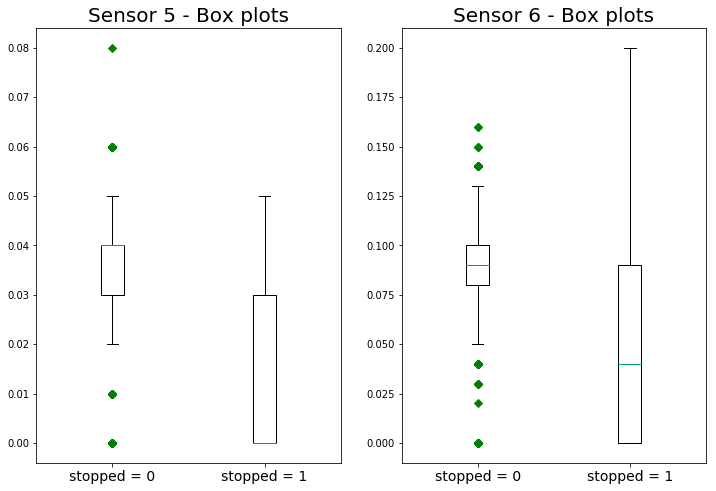

In [45]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))
ax1.boxplot([df_SD2[df_SD2['stopped'] == 0]['sensor 5'], df_SD2[df_SD2['stopped'] == 1]['sensor 5']], 0, 'gD')
ax2.boxplot([df_SD2[df_SD2['stopped'] == 0]['sensor 6'], df_SD2[df_SD2['stopped'] == 1]['sensor 6']], 0, 'gD')

ax1.set_title('Sensor 5 - Box plots', fontsize=20)
ax2.set_title('Sensor 6 - Box plots', fontsize=20)

labels = ['stopped = 0', 'stopped = 1']
ax1.set_xticklabels(labels, fontsize=14)
ax2.set_xticklabels(labels, fontsize=14)

[Text(0, 0, 'stopped = 0'), Text(0, 0, 'stopped = 1')]

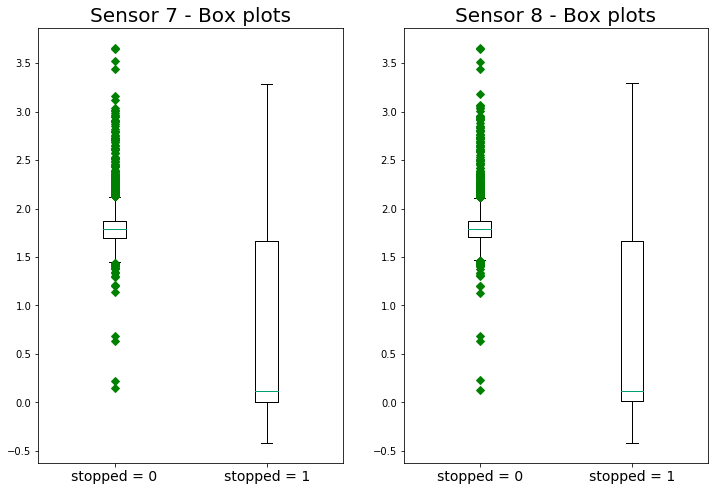

In [46]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))
ax1.boxplot([df_SD2[df_SD2['stopped'] == 0]['sensor 7'], df_SD2[df_SD2['stopped'] == 1]['sensor 7']], 0, 'gD')
ax2.boxplot([df_SD2[df_SD2['stopped'] == 0]['sensor 8'], df_SD2[df_SD2['stopped'] == 1]['sensor 8']], 0, 'gD')

ax1.set_title('Sensor 7 - Box plots', fontsize=20)
ax2.set_title('Sensor 8 - Box plots', fontsize=20)

labels = ['stopped = 0', 'stopped = 1']
ax1.set_xticklabels(labels, fontsize=14)
ax2.set_xticklabels(labels, fontsize=14)

[Text(0, 0, 'stopped = 0'), Text(0, 0, 'stopped = 1')]

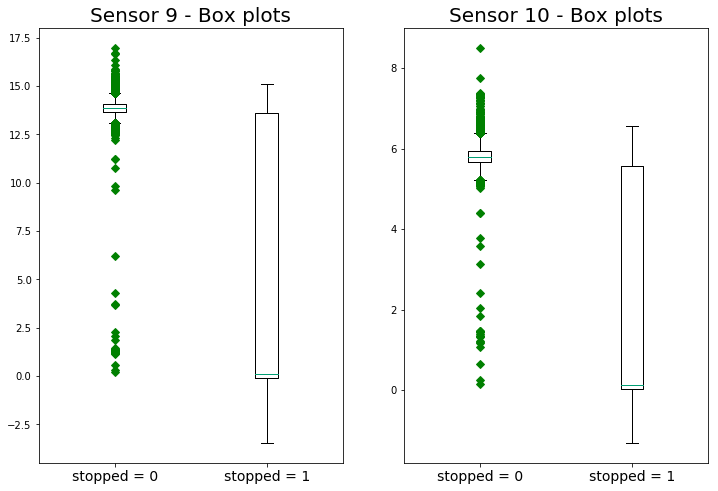

In [47]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))
ax1.boxplot([df_SD2[df_SD2['stopped'] == 0]['sensor 9'], df_SD2[df_SD2['stopped'] == 1]['sensor 9']], 0, 'gD')
ax2.boxplot([df_SD2[df_SD2['stopped'] == 0]['sensor 10'], df_SD2[df_SD2['stopped'] == 1]['sensor 10']], 0, 'gD')

ax1.set_title('Sensor 9 - Box plots', fontsize=20)
ax2.set_title('Sensor 10 - Box plots', fontsize=20)

labels = ['stopped = 0', 'stopped = 1']
ax1.set_xticklabels(labels, fontsize=14)
ax2.set_xticklabels(labels, fontsize=14)

[Text(0, 0, 'stopped = 0'), Text(0, 0, 'stopped = 1')]

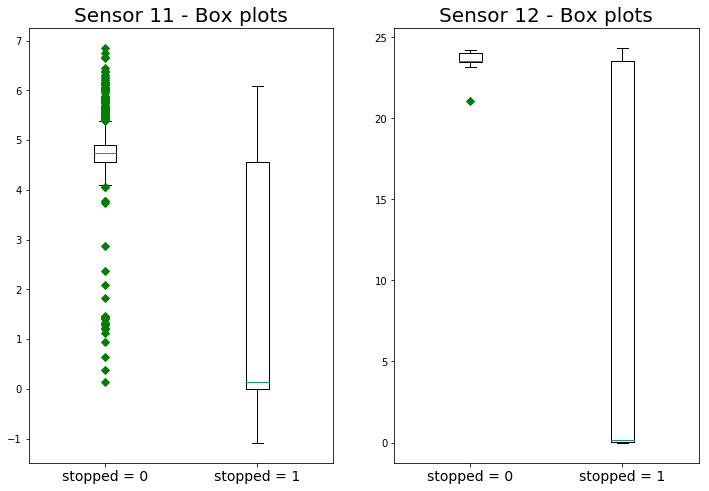

In [48]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))
ax1.boxplot([df_SD2[df_SD2['stopped'] == 0]['sensor 11'], df_SD2[df_SD2['stopped'] == 1]['sensor 11']], 0, 'gD')
ax2.boxplot([df_SD2[df_SD2['stopped'] == 0]['sensor 12'], df_SD2[df_SD2['stopped'] == 1]['sensor 12']], 0, 'gD')

ax1.set_title('Sensor 11 - Box plots', fontsize=20)
ax2.set_title('Sensor 12 - Box plots', fontsize=20)

labels = ['stopped = 0', 'stopped = 1']
ax1.set_xticklabels(labels, fontsize=14)
ax2.set_xticklabels(labels, fontsize=14)

[Text(0, 0, 'stopped = 0'), Text(0, 0, 'stopped = 1')]

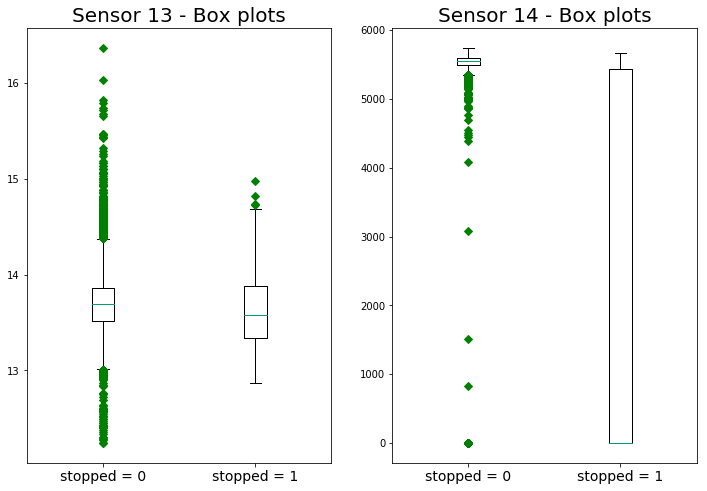

In [49]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))
ax1.boxplot([df_SD2[df_SD2['stopped'] == 0]['sensor 13'], df_SD2[df_SD2['stopped'] == 1]['sensor 13']], 0, 'gD')
ax2.boxplot([df_SD2[df_SD2['stopped'] == 0]['sensor 14'], df_SD2[df_SD2['stopped'] == 1]['sensor 14']], 0, 'gD')

ax1.set_title('Sensor 13 - Box plots', fontsize=20)
ax2.set_title('Sensor 14 - Box plots', fontsize=20)

labels = ['stopped = 0', 'stopped = 1']
ax1.set_xticklabels(labels, fontsize=14)
ax2.set_xticklabels(labels, fontsize=14)

[Text(0, 0, 'stopped = 0'), Text(0, 0, 'stopped = 1')]

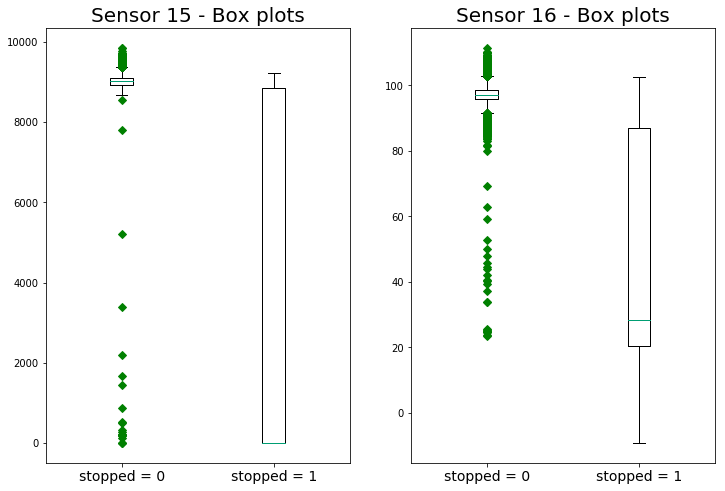

In [50]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))
ax1.boxplot([df_SD2[df_SD2['stopped'] == 0]['sensor 15'], df_SD2[df_SD2['stopped'] == 1]['sensor 15']], 0, 'gD')
ax2.boxplot([df_SD2[df_SD2['stopped'] == 0]['sensor 16'], df_SD2[df_SD2['stopped'] == 1]['sensor 16']], 0, 'gD')

ax1.set_title('Sensor 15 - Box plots', fontsize=20)
ax2.set_title('Sensor 16 - Box plots', fontsize=20)

labels = ['stopped = 0', 'stopped = 1']
ax1.set_xticklabels(labels, fontsize=14)
ax2.set_xticklabels(labels, fontsize=14)

[Text(0, 0, 'stopped = 0'), Text(0, 0, 'stopped = 1')]

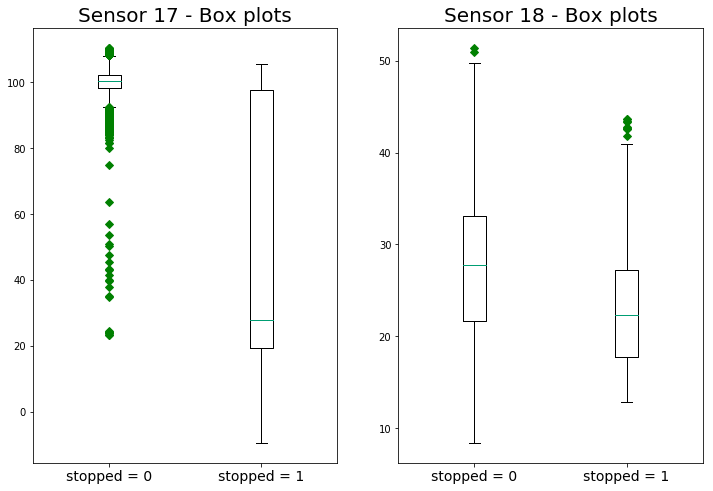

In [51]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))
ax1.boxplot([df_SD2[df_SD2['stopped'] == 0]['sensor 17'], df_SD2[df_SD2['stopped'] == 1]['sensor 17']], 0, 'gD')
ax2.boxplot([df_SD2[df_SD2['stopped'] == 0]['sensor 18'], df_SD2[df_SD2['stopped'] == 1]['sensor 18']], 0, 'gD')

ax1.set_title('Sensor 17 - Box plots', fontsize=20)
ax2.set_title('Sensor 18 - Box plots', fontsize=20)

labels = ['stopped = 0', 'stopped = 1']
ax1.set_xticklabels(labels, fontsize=14)
ax2.set_xticklabels(labels, fontsize=14)

[Text(0, 0, 'stopped = 0'), Text(0, 0, 'stopped = 1')]

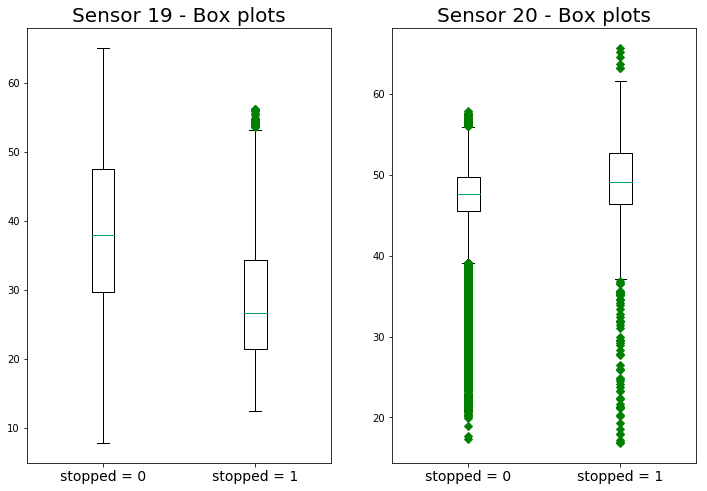

In [52]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))
ax1.boxplot([df_SD2[df_SD2['stopped'] == 0]['sensor 19'], df_SD2[df_SD2['stopped'] == 1]['sensor 19']], 0, 'gD')
ax2.boxplot([df_SD2[df_SD2['stopped'] == 0]['sensor 20'], df_SD2[df_SD2['stopped'] == 1]['sensor 20']], 0, 'gD')

ax1.set_title('Sensor 19 - Box plots', fontsize=20)
ax2.set_title('Sensor 20 - Box plots', fontsize=20)

labels = ['stopped = 0', 'stopped = 1']
ax1.set_xticklabels(labels, fontsize=14)
ax2.set_xticklabels(labels, fontsize=14)

[Text(0, 0, 'stopped = 0'), Text(0, 0, 'stopped = 1')]

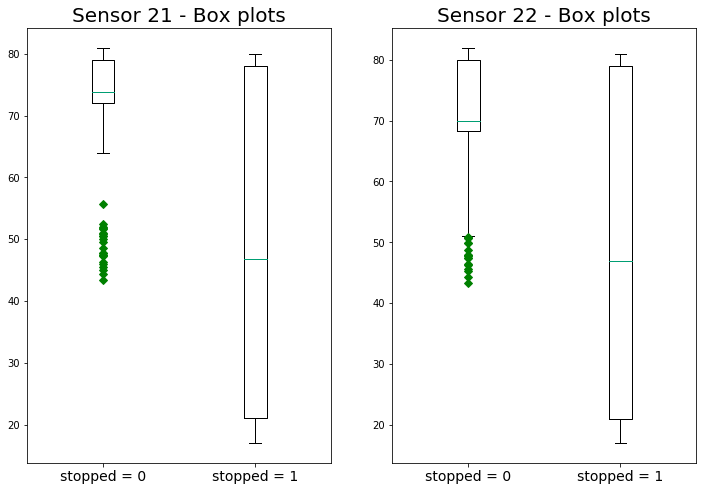

In [53]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))
ax1.boxplot([df_SD2[df_SD2['stopped'] == 0]['sensor 21'], df_SD2[df_SD2['stopped'] == 1]['sensor 21']], 0, 'gD')
ax2.boxplot([df_SD2[df_SD2['stopped'] == 0]['sensor 22'], df_SD2[df_SD2['stopped'] == 1]['sensor 22']], 0, 'gD')

ax1.set_title('Sensor 21 - Box plots', fontsize=20)
ax2.set_title('Sensor 22 - Box plots', fontsize=20)

labels = ['stopped = 0', 'stopped = 1']
ax1.set_xticklabels(labels, fontsize=14)
ax2.set_xticklabels(labels, fontsize=14)

[Text(0, 0, 'stopped = 0'), Text(0, 0, 'stopped = 1')]

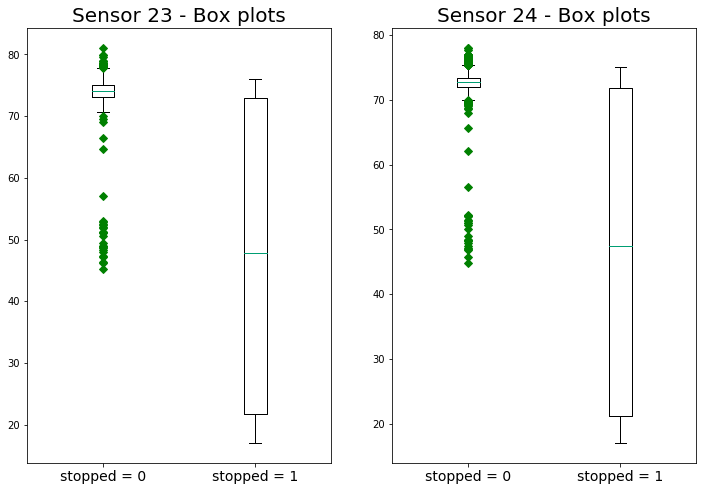

In [54]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))
ax1.boxplot([df_SD2[df_SD2['stopped'] == 0]['sensor 23'], df_SD2[df_SD2['stopped'] == 1]['sensor 23']], 0, 'gD')
ax2.boxplot([df_SD2[df_SD2['stopped'] == 0]['sensor 24'], df_SD2[df_SD2['stopped'] == 1]['sensor 24']], 0, 'gD')

ax1.set_title('Sensor 23 - Box plots', fontsize=20)
ax2.set_title('Sensor 24 - Box plots', fontsize=20)

labels = ['stopped = 0', 'stopped = 1']
ax1.set_xticklabels(labels, fontsize=14)
ax2.set_xticklabels(labels, fontsize=14)

[Text(0, 0, 'stopped = 0'), Text(0, 0, 'stopped = 1')]

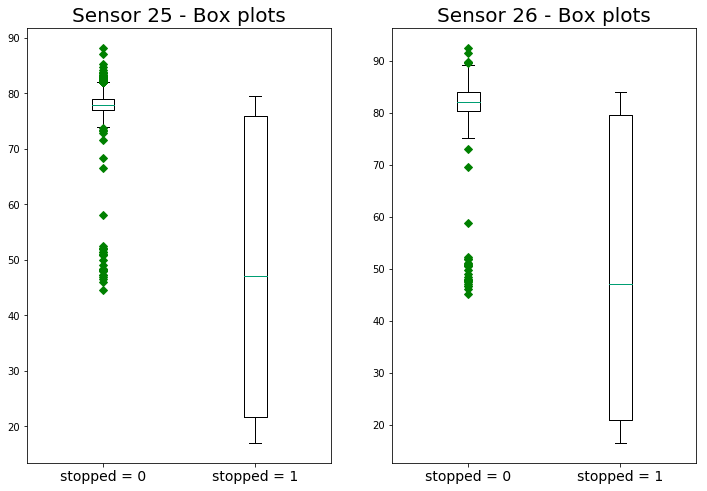

In [55]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))
ax1.boxplot([df_SD2[df_SD2['stopped'] == 0]['sensor 25'], df_SD2[df_SD2['stopped'] == 1]['sensor 25']], 0, 'gD')
ax2.boxplot([df_SD2[df_SD2['stopped'] == 0]['sensor 26'], df_SD2[df_SD2['stopped'] == 1]['sensor 26']], 0, 'gD')

ax1.set_title('Sensor 25 - Box plots', fontsize=20)
ax2.set_title('Sensor 26 - Box plots', fontsize=20)

labels = ['stopped = 0', 'stopped = 1']
ax1.set_xticklabels(labels, fontsize=14)
ax2.set_xticklabels(labels, fontsize=14)

[Text(0, 0, 'stopped = 0'), Text(0, 0, 'stopped = 1')]

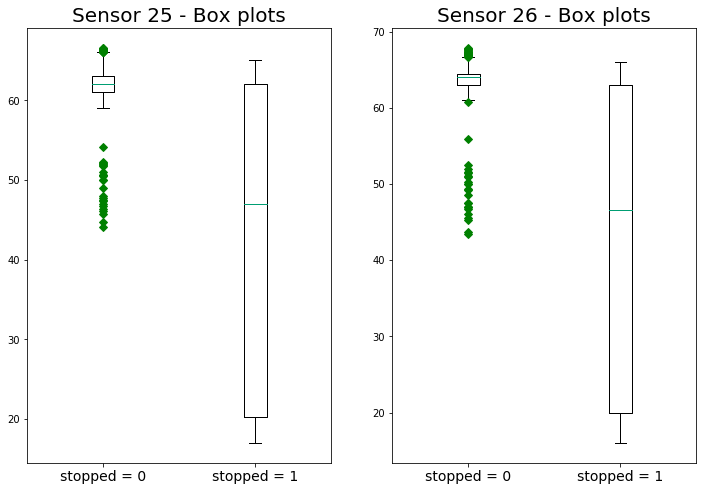

In [56]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))
ax1.boxplot([df_SD2[df_SD2['stopped'] == 0]['sensor 27'], df_SD2[df_SD2['stopped'] == 1]['sensor 27']], 0, 'gD')
ax2.boxplot([df_SD2[df_SD2['stopped'] == 0]['sensor 28'], df_SD2[df_SD2['stopped'] == 1]['sensor 28']], 0, 'gD')

ax1.set_title('Sensor 25 - Box plots', fontsize=20)
ax2.set_title('Sensor 26 - Box plots', fontsize=20)

labels = ['stopped = 0', 'stopped = 1']
ax1.set_xticklabels(labels, fontsize=14)
ax2.set_xticklabels(labels, fontsize=14)

[Text(0, 0, 'stopped = 0'), Text(0, 0, 'stopped = 1')]

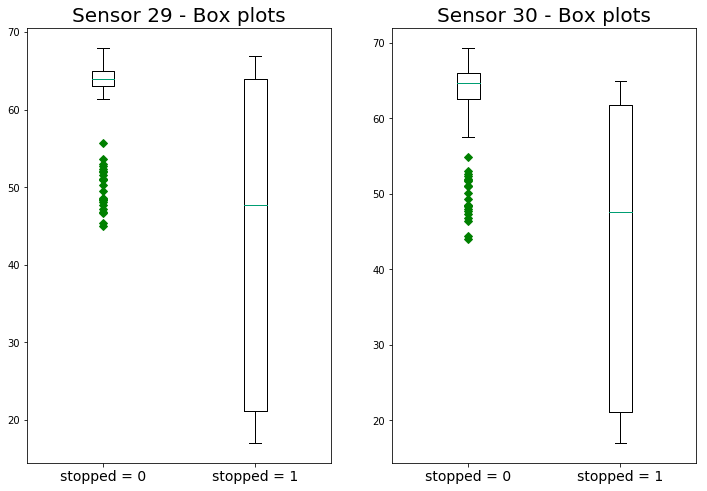

In [57]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))
ax1.boxplot([df_SD2[df_SD2['stopped'] == 0]['sensor 29'], df_SD2[df_SD2['stopped'] == 1]['sensor 29']], 0, 'gD')
ax2.boxplot([df_SD2[df_SD2['stopped'] == 0]['sensor 30'], df_SD2[df_SD2['stopped'] == 1]['sensor 30']], 0, 'gD')

ax1.set_title('Sensor 29 - Box plots', fontsize=20)
ax2.set_title('Sensor 30 - Box plots', fontsize=20)

labels = ['stopped = 0', 'stopped = 1']
ax1.set_xticklabels(labels, fontsize=14)
ax2.set_xticklabels(labels, fontsize=14)

[Text(0, 0, 'stopped = 0'), Text(0, 0, 'stopped = 1')]

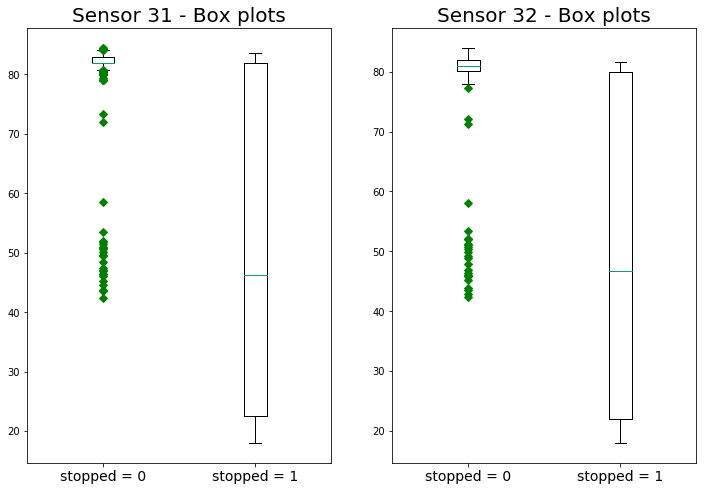

In [58]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))
ax1.boxplot([df_SD2[df_SD2['stopped'] == 0]['sensor 31'], df_SD2[df_SD2['stopped'] == 1]['sensor 31']], 0, 'gD')
ax2.boxplot([df_SD2[df_SD2['stopped'] == 0]['sensor 32'], df_SD2[df_SD2['stopped'] == 1]['sensor 32']], 0, 'gD')

ax1.set_title('Sensor 31 - Box plots', fontsize=20)
ax2.set_title('Sensor 32 - Box plots', fontsize=20)

labels = ['stopped = 0', 'stopped = 1']
ax1.set_xticklabels(labels, fontsize=14)
ax2.set_xticklabels(labels, fontsize=14)

From inspection of the above plots it is evident that there are features that provide very good separation between the classes (e.g. sensors 23, 24, 25 and 26). This is very encouraging since such features will enable us to build a model with good predictive power. 

# 3.- Model Build

## 3.1.- Shuffle data

We will shuffle the data in order to guarantee an even distribution of labels throughtout the dataset; additionally we will specify a stratified test-train split.

In [59]:
df_SD3 = df_SD2.drop('DateTime', axis=1)
df_SD3 = df_SD3.sample(frac=1, random_state=RANDOM_STATE)
df_SD3 = df_SD3.sample(frac=1, random_state=RANDOM_STATE)
df_SD3 = df_SD3.sample(frac=1, random_state=RANDOM_STATE)

## 3.2.- Training and testing sets

In [60]:
y = df_SD3['stopped'].values

In [61]:
X = df_SD3.drop(['stopped'], axis=1).values

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE)

We verify that the target feature is equally represented in the training and testing sets

In [63]:
100*np.bincount(y_train)/float(len(y_train))

array([95.91404596,  4.08595404])

In [64]:
100*np.bincount(y_test)/float(len(y_test))

array([95.91948765,  4.08051235])

## 3.3.- Model definition

For this exercise we will use a random forest classifier for several reasons: a) the data does not require prior scaling, therefore requiring a simpler deployment pipeline; b) the random forests algorithm is less prone to overfitting; c) a random forest algorithm is robust against noisy/missing data; d) it runs efficiently on large datasets with excellent performance; e) feature importance calculation is embedded into the Sklearn implementation and can be easily obtained. Since no hyperparameter tuning will be performed at this stage we will use the default parameters for the random forest classifier (aside from specifying the  number of trees in the forest.)

In [65]:
clf = RandomForestClassifier(n_estimators = 100, random_state=RANDOM_STATE, n_jobs=-1) 

## 3.4.- Model training

In [66]:
model = clf.fit(X_train, y_train)

## 3.5.- Model evaluation

As in every imbalanced classes classification problem, evaluating a model's performance in terms of accuracy can lead to erroneous results, and therefore we will be looking at other measures of model performance such as precision, recall, confusion matirx, ROC curve, AUC and precision-recall curve.

### 3.5.1.- Performance on test set - confusion matrix

In [67]:
y_pred = model.predict(X_test)

In [68]:
confusion = confusion_matrix(y_test, y_pred)
confusion

array([[5237,    5],
       [  37,  186]])

Text(0.5, 1.0, 'Random Forest Model')

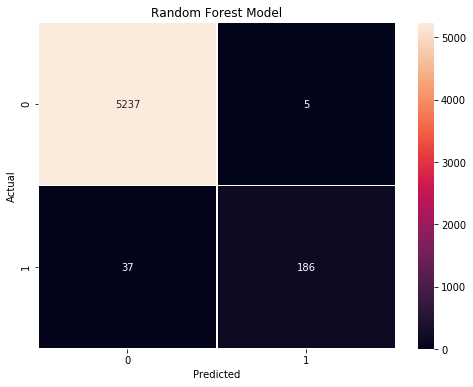

In [69]:
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.heatmap(confusion, annot=True, fmt="d", linewidths=.5)
ax.set(xlabel='Predicted', ylabel='Actual')
ax.set_title('Random Forest Model')

### 3.5.2.- Performance on test set - recall

In [70]:
recall_score(y_test, y_pred)

0.8340807174887892

### 3.5.3.- Performance on test set - precision

In [71]:
precision_score(y_test, y_pred)

0.9738219895287958

### 3.5.4.- Performance on test set - ROC curve

In [72]:
# Compute fpr, tpr, thresholds and roc auc
probs = clf.predict_proba(X_test)
y_score = probs[:,1]
fpr, tpr, thresholds1 = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

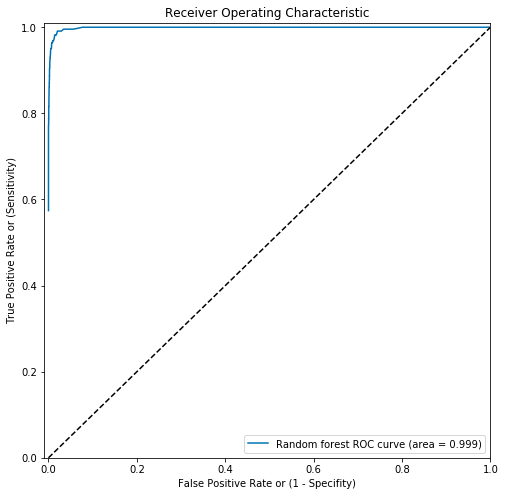

In [73]:
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, label='Random forest ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

### 3.5.5.- Performance on test set - precision/recall curve

In [74]:
precision, recall, _ = precision_recall_curve(y_test, y_score)

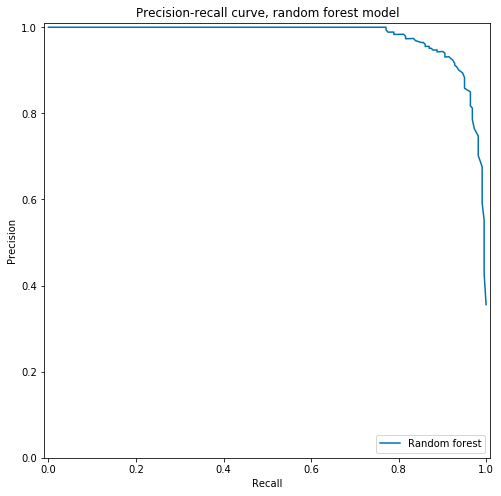

In [75]:
plt.figure(figsize=(8,8))
plt.plot(recall, precision, label='Random forest')
plt.xlim([-0.01, 1.01])
plt.ylim([0.0, 1.01])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-recall curve, random forest model')
plt.legend(loc="lower right")

As evidenced by the performance measures, the model does quite well in terms of detecting machine failure, as with the default decision threshold the precision and recall (95% and 73%) are quite satisfactory. These indicators can however be adjusted to meet business requirements as indicated by the precision-recall plot. Lastly, the ROC curve is quite close to a theoretical optimum, as indicated by an AUC of 0.99.

## 3.6.- Feature importances

In [76]:
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = df_SD3.drop(['stopped'], axis=1).columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

In [77]:
feature_importances.head(32)

,importance
sensor 16,0.097983
sensor 3,0.079370
sensor 10,0.077080
sensor 1,0.074346
sensor 14,0.070613
sensor 23,0.060921
sensor 15,0.057049
sensor 25,0.055748
sensor 30,0.047896
sensor 28,0.045699


The features importances obtained from the model are in agreement with the observations made during the exploratory analysis. 

Text(0, 0.5, 'Relative Importance')

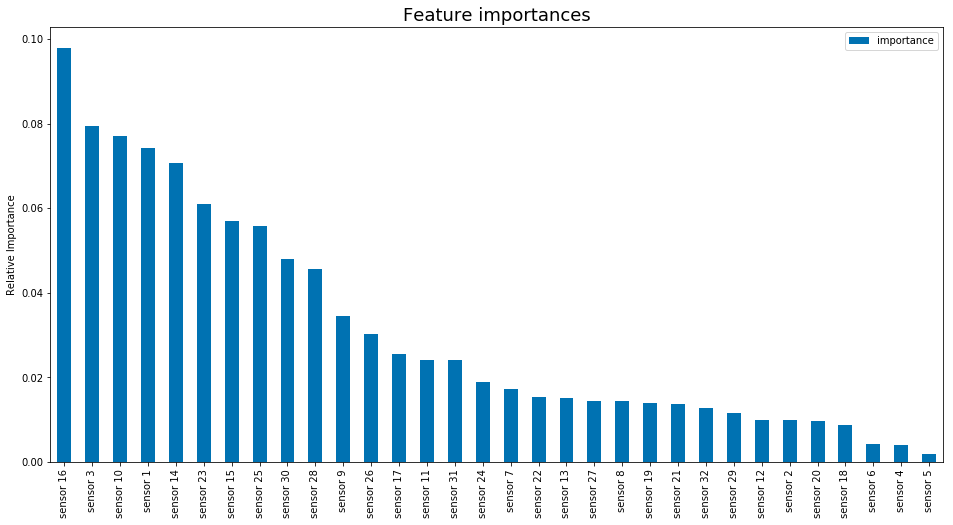

In [78]:
axes = feature_importances.plot.bar(figsize=(16,8))
plt.title('Feature importances', fontsize=18)
plt.ylabel('Relative Importance')